In [ ]:
# Importing necessary libraries
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical computing
import seaborn as sns
import matplotlib.pyplot as plt  # Basic plotting
from statsmodels.tsa.arima.model import ARIMA  # ARIMA model for time series forecasting
from statsmodels.tsa.stattools import adfuller, acf, pacf  # ADF test, ACF, and PACF functions
import statsmodels.api as sm  # Seasonal ARIMA and other statistical tools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # ACF and PACF plotting


# Metrics for evaluating the performance of models
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt  # Square root function for calculating RMSE

# Decomposition of time series into seasonal, trend, and residual components
from statsmodels.tsa.seasonal import seasonal_decompose


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Load Dataset:

In [ ]:
# loading dataset
df = pd.read_csv("/content/drive/MyDrive/0.Latest_DS_Course/SL/TimeSeries/NoteBooks/AirPassengers.csv")

df.head()


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


### Correct Datatype:

In [ ]:
# Convert 'Month' to datetime format and set it as index
df['Month'] = pd.to_datetime(df['Month'])


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


## Setting month as index:

* The date column is set as the index immediately after loading the dataset.

* This standard practice streamlines time-based operations in Pandas.

* It enables smooth implementation of models like ARIMA, SARIMA, and SARIMAX.

In [ ]:
df.set_index('Month', inplace=True)


print(df)

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121
...                 ...
1960-08-01          606
1960-09-01          508
1960-10-01          461
1960-11-01          390
1960-12-01          432

[144 rows x 1 columns]


## Visualizing Data:

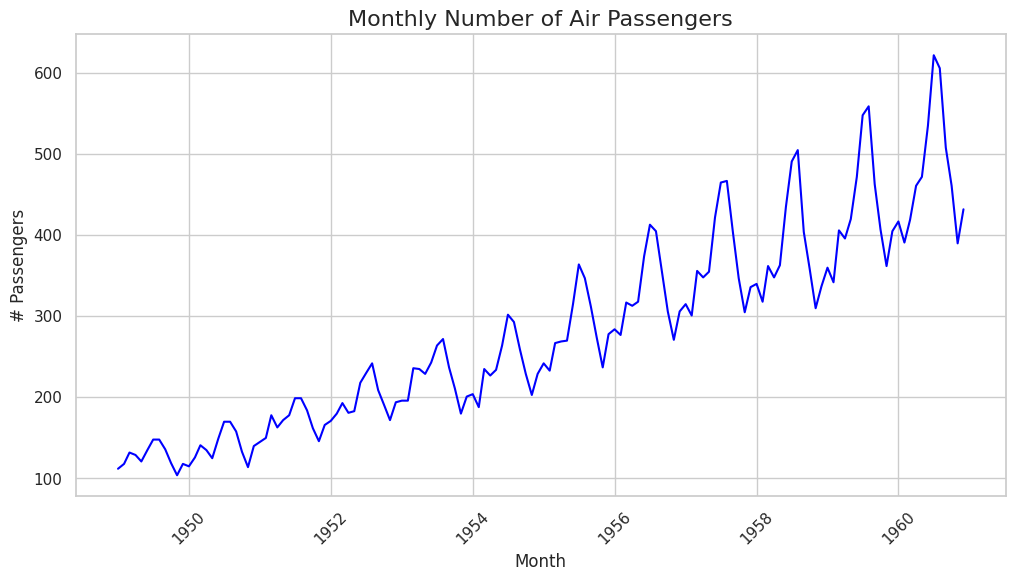

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=df.index, y=df['#Passengers'], color='blue')

# Customize the plot
plt.title('Monthly Number of Air Passengers', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('# Passengers', fontsize=12)

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

---
##**Checking stationarity**
#### Method 1 - Visual apporach using  Rolling Statistics
#### Method 2 -  Statistics tests using Duckey fuller
---

###Method 1: Rolling Statistics

## <center> Rolling Statistics

* A rolling average is a great way to visualize how the dataset is trending.
* As the dataset provides counts by month, a window size of 12 will give us the annual rolling average.

* We will also include the rolling standard deviation to see how much the data varies from the rolling average.

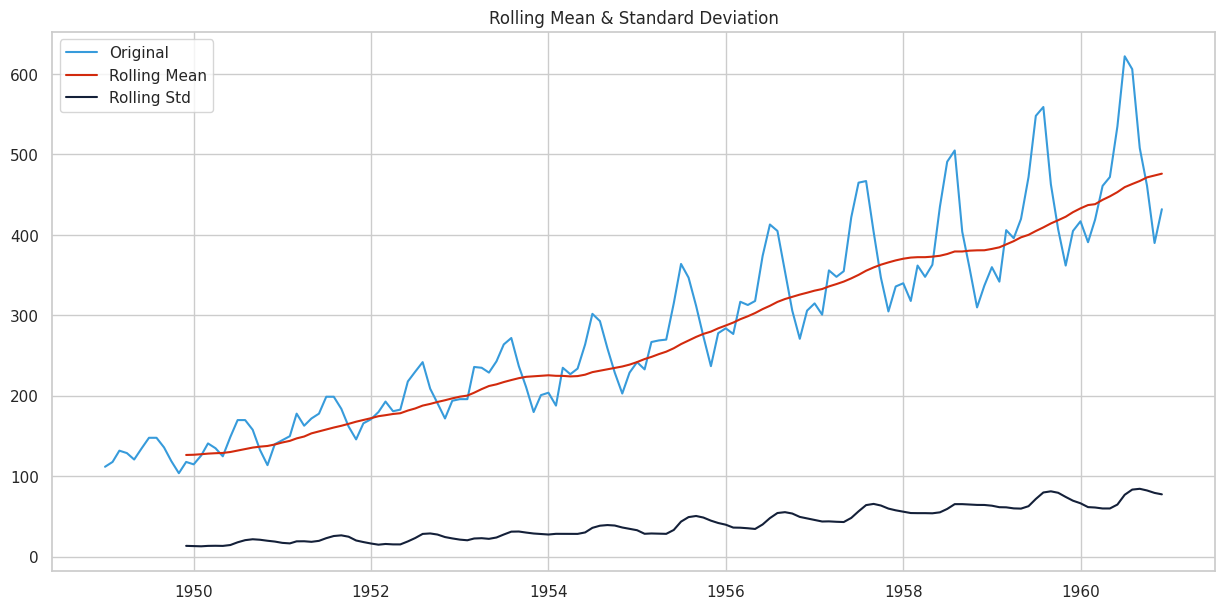

In [ ]:
#Determine rolling statistics
df["rolling_avg"] = df["#Passengers"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df["rolling_std"] = df["#Passengers"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["#Passengers"], color='#379BDB', label='Original')
plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

---

### **Observations: Rolling Mean & Standard Deviation Plot**

#### 1. **Trend**
- The **original time series (blue line)** shows a **clear upward trend**.
- The **rolling mean (red line)** steadily increases, confirming that the data is **non-stationary** due to a strong trend.

#### 2. **Seasonality**
- The blue line shows **regular up-and-down patterns**, indicating **seasonality** (likely monthly data with yearly cycles).
- The amplitude of the seasonal component increases over time — this suggests **multiplicative seasonality**.

#### 3. **Variance/Volatility**
- The **rolling standard deviation (black line)** increases slightly over time but remains relatively stable.


#### 4. **Stationarity Check**
- Since both the **mean and standard deviation are not constant over time**, the time series is **not stationary**.
- Stationarity is a key assumption for many time series models (like ARIMA), so this series would require **differencing or transformation** to make it stationary.

---




###Method 2: Dickey-Fuller test



###**How to Interpret the Results:**

| Result         | What it Means                                 |
|----------------|------------------------------------------------|
| **p-value > 0.05** | **Fail to reject** null hypothesis → Time series is **non-stationary** |
| **p-value ≤ 0.05** | **Reject** null hypothesis → Time series is **stationary** |
| ADF Statistic < Critical Value | Strong evidence for stationarity |

---



In [ ]:
result=adfuller(df['#Passengers'])


In [ ]:
result

(np.float64(0.8153688792060498),
 np.float64(0.991880243437641),
 13,
 130,
 {'1%': np.float64(-3.4816817173418295),
  '5%': np.float64(-2.8840418343195267),
  '10%': np.float64(-2.578770059171598)},
 np.float64(996.692930839019))

In [ ]:
#  Augmented Dickey-Fuller test function
def adfuller_test(passengers):
    result=adfuller(passengers)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("\n---- Test Result -----")

        print("Strong evidence against the null hypothesis(Ho), so reject the null hypothesis. Say Data is stationary")
        print("Good to go for ARIMA")
    else:
        print("\n---- Test Result -----")
        print("Weak evidence against null hypothesis,indicating it is non-stationary. ")
        print("Non Stationary so need Differencing")

adfuller_test(df['#Passengers'])

ADF Test Statistic : 0.8153688792060498
p-value : 0.991880243437641
#Lags Used : 13
Number of Observations : 130

---- Test Result -----
Weak evidence against null hypothesis,indicating it is non-stationary. 
Non Stationary so need Differencing


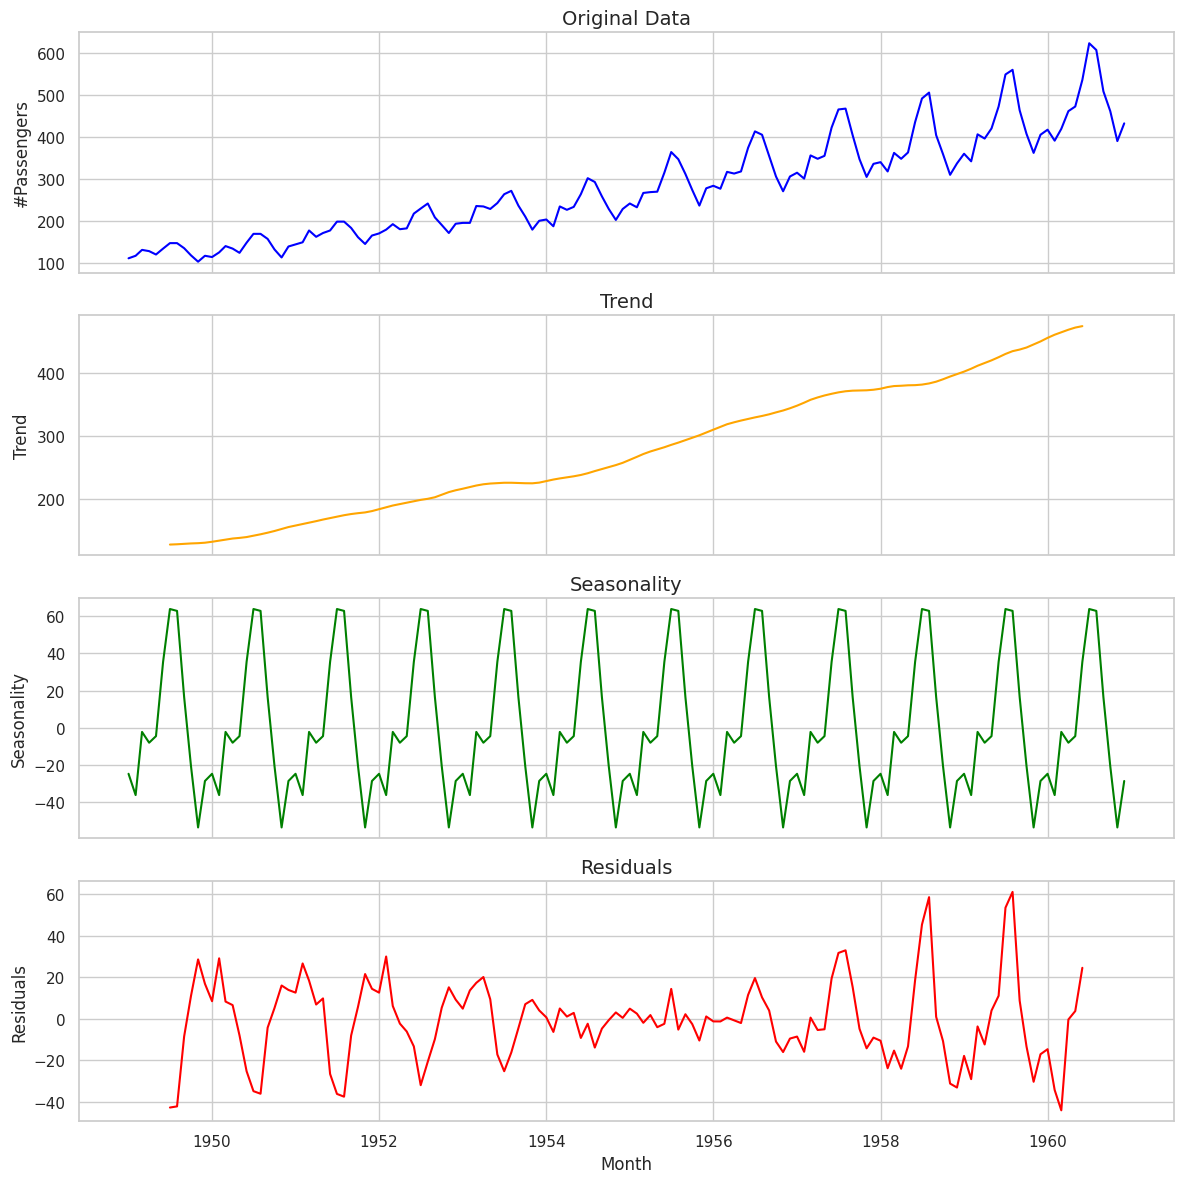

In [ ]:

# Decompose the time series data into trend, seasonal, and residual components
decomposition = seasonal_decompose(df['#Passengers'], period=12)  # Adjust the period as needed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Set the style of the plot
sns.set(style="whitegrid")

# Create a figure and axes for subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Plot the original data
axes[0].plot(df.index, df['#Passengers'], color='blue')
axes[0].set_title('Original Data', fontsize=14)
axes[0].set_ylabel('#Passengers', fontsize=12)

# Plot the trend component
axes[1].plot(df.index, trend, color='orange')
axes[1].set_title('Trend', fontsize=14)
axes[1].set_ylabel('Trend', fontsize=12)

# Plot the seasonal component
axes[2].plot(df.index, seasonal, color='green')
axes[2].set_title('Seasonality', fontsize=14)
axes[2].set_ylabel('Seasonality', fontsize=12)

# Plot the residual component
axes[3].plot(df.index, residual, color='red')
axes[3].set_title('Residuals', fontsize=14)
axes[3].set_ylabel('Residuals', fontsize=12)

# Set common xlabel
plt.xlabel('Month', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

### Making Data Stationary

In [ ]:
df['Passengers First Difference'] = df['#Passengers'] - df['#Passengers'].shift(1)
df['Seasonal First Difference']=df['#Passengers']-df['#Passengers'].shift(12)
df.head()

,#Passengers,rolling_avg,rolling_std,Passengers First Difference,Seasonal First Difference
Month,,,,,
1949-01-01,112,NaN,NaN,NaN,NaN
1949-02-01,118,NaN,NaN,6.0,NaN
1949-03-01,132,NaN,NaN,14.0,NaN
1949-04-01,129,NaN,NaN,-3.0,NaN
1949-05-01,121,NaN,NaN,-8.0,NaN


### Perform ADF Test Again to check Stationary

In [ ]:
# Again testing if data is stationary- we need to just call the adfuller_test function
adfuller_test(df['Passengers First Difference'].dropna())

ADF Test Statistic : -2.8292668241700047
p-value : 0.05421329028382478
#Lags Used : 12
Number of Observations : 130

---- Test Result -----
Weak evidence against null hypothesis,indicating it is non-stationary. 
Non Stationary so need Differencing


In [ ]:
df['Passengers second Difference'] = df['#Passengers'] - df['#Passengers'].shift(2)


In [ ]:
adfuller_test(df['Passengers second Difference'].dropna())

ADF Test Statistic : -2.961695135555418
p-value : 0.03862975767698902
#Lags Used : 11
Number of Observations : 130

---- Test Result -----
Strong evidence against the null hypothesis(Ho), so reject the null hypothesis. Say Data is stationary
Good to go for ARIMA


### to make the data stationary we need d=2

In [ ]:
# Again testing if data is stationary- we need to just call the adfuller_test function
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic : -3.383020726492481
p-value : 0.011551493085514952
#Lags Used : 1
Number of Observations : 130

---- Test Result -----
Strong evidence against the null hypothesis(Ho), so reject the null hypothesis. Say Data is stationary
Good to go for ARIMA


### to make seasonal data stationary we need one season diff

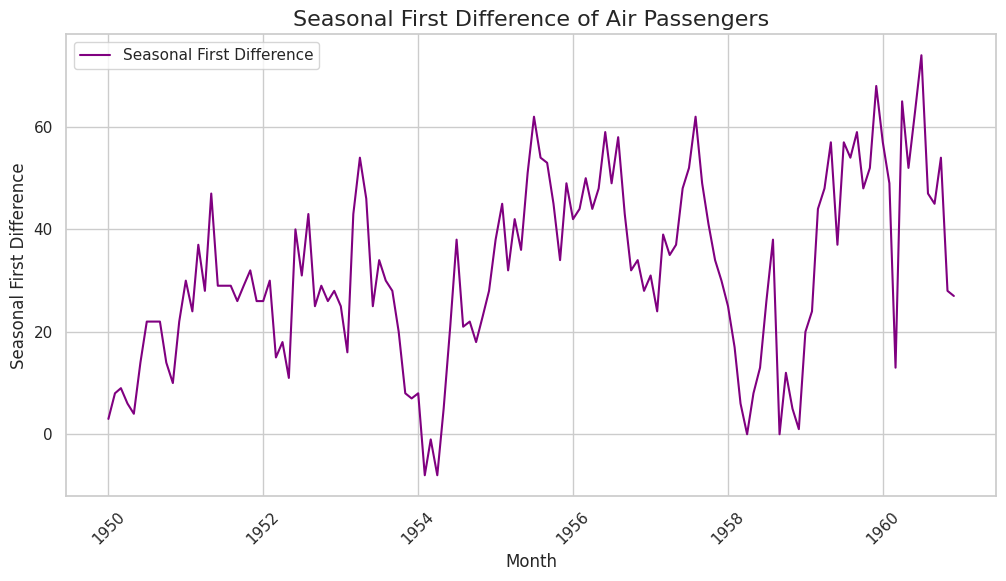

In [ ]:

# Set the style of the plot
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the 'Seasonal First Difference' column
plt.plot(df.index, df['Seasonal First Difference'], color='purple', label='Seasonal First Difference')

# Customize the plot
plt.title('Seasonal First Difference of Air Passengers', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Seasonal First Difference', fontsize=12)
plt.legend()

# Show the grid and x/y axis lines
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

### Determining the Orders Of AR and MA:

In [ ]:

# Number of observations
N = len(df['Seasonal First Difference'].dropna())

# Calculate ACF and PACF values
acf_values, acf_confint = acf(df['Seasonal First Difference'].dropna(), nlags=40, alpha=0.05)  # 95% CI for ACF
pacf_values, pacf_confint = pacf(df['Seasonal First Difference'].dropna(), nlags=40, alpha=0.05)  # 95% CI for PACF




In [ ]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(acf_values, nlags=20)
lag_pacf = pacf(pacf_values, nlags=20)

##**p (AR order) is chosen using the PACF (Partial Autocorrelation Function) plot**

##**q (MA order) is chosen using the ACF (Autocorrelation Function) plot**

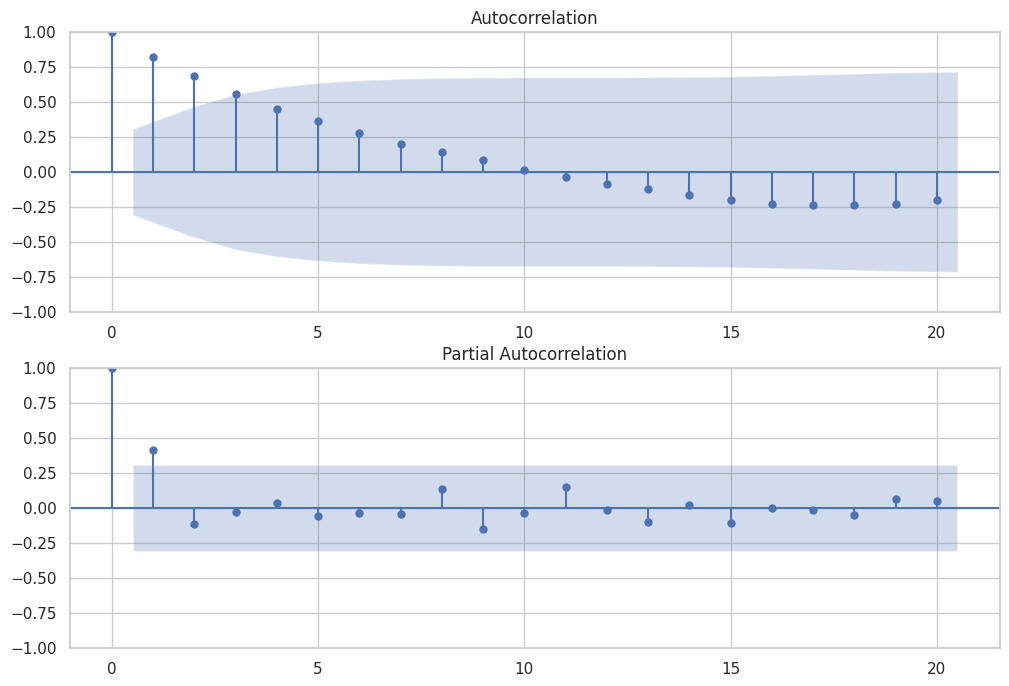

In [ ]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(acf_values,lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(pacf_values,lags=20,ax=ax2)

#Observations:
* p=1(ACF) and q=2(PACF)

* **so finally p=1, d=2 and q=2 for ARIMA**

### Splitting the Data

In [ ]:

# Split the data into training and testing sets
train = df[:-12]
test = df[-12:]

### Build ARIMA Model:

In [ ]:
# Fit ARIMA Model
model_arima = ARIMA(train['#Passengers'], order=(1, 2, 2))  # (p, d, q) values can be tuned
results_arima = model_arima.fit()

# Forecast for the next 12 months
forecast_arima = results_arima.forecast(steps=12)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


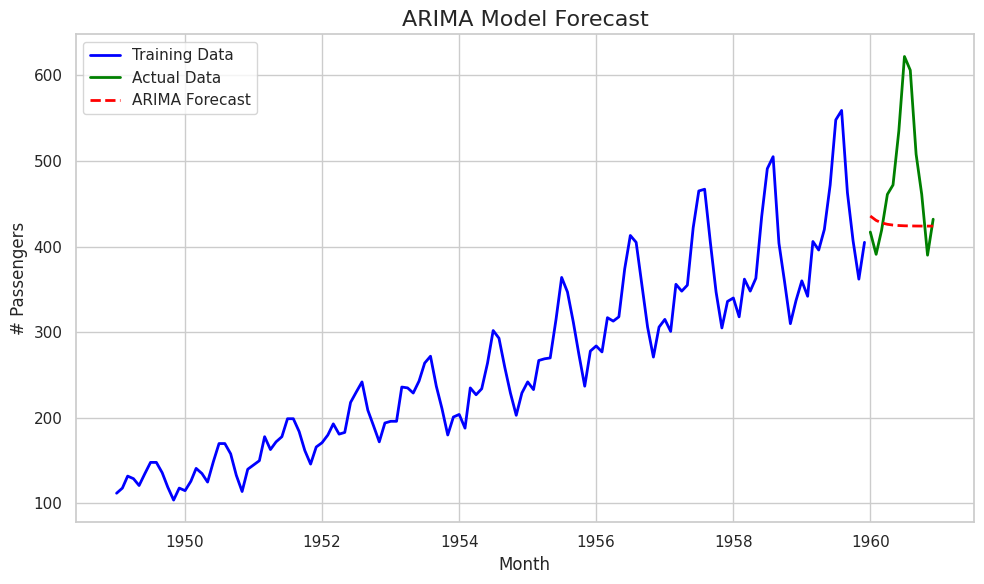

In [ ]:

# Plotting the ARIMA forecast using Matplotlib
plt.figure(figsize=(10, 6))

# Plot training data
plt.plot(train.index, train['#Passengers'], label='Training Data', color='blue', linestyle='-', linewidth=2)

# Plot actual test data
plt.plot(test.index, test['#Passengers'], label='Actual Data', color='green', linestyle='-', linewidth=2)

# Plot ARIMA forecast
plt.plot(test.index, forecast_arima, label='ARIMA Forecast', color='red', linestyle='--', linewidth=2)

# Adding title and labels
plt.title('ARIMA Model Forecast', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('# Passengers', fontsize=12)

# Add grid for better readability
plt.grid(True)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

### Calculate performance metrics


In [ ]:
# Calculate performance metrics
mae = mean_absolute_error(test['#Passengers'], forecast_arima)
mse = mean_squared_error(test['#Passengers'], forecast_arima)
rmse = sqrt(mse)

print(f"ARIMA Model Performance:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


ARIMA Model Performance:
Mean Absolute Error (MAE): 66.80770200297322
Mean Squared Error (MSE): 8281.560173582804
Root Mean Squared Error (RMSE): 91.00307782477911


In [ ]:
results_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                  132
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -622.487
Date:                Mon, 21 Apr 2025   AIC                           1252.974
Time:                        02:20:51   BIC                           1264.474
Sample:                    01-01-1949   HQIC                          1257.647
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5673      0.105      5.382      0.000       0.361       0.774
ma.L1         -0.3351      0.105     -3.198      0.001      -0.540      -0.130
ma.L2         -0.4825      0.074     -6.529      0.000      -0.627      -0.338
sigma2       781.3644     96.191      8.123      0.000     592.834     969.894
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 0.08
Prob(Q):                              0.80   Prob(JB):                         0.96
Heteroskedasticity (H):               7.09   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Build SARIMA Model:

In [ ]:
# Split the data into training and testing sets
train = df[:-12]
test = df[-12:]

# Fit SARIMA Model
model_sarima = sm.tsa.statespace.SARIMAX(train['#Passengers'],
                                         order=(1, 2, 2),       # Non-seasonal (p, d, q)
                                         seasonal_order=(1, 1, 1, 12))  # Seasonal (P, D, Q, s)
results_sarima = model_sarima.fit()

# Forecast for the next 12 months with SARIMA
forecast_sarima = results_sarima.get_forecast(steps=12)
forecast_mean_sarima = forecast_sarima.predicted_mean
confidence_interval_sarima = forecast_sarima.conf_int()  # it gives us range within which we can expecte the value





/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


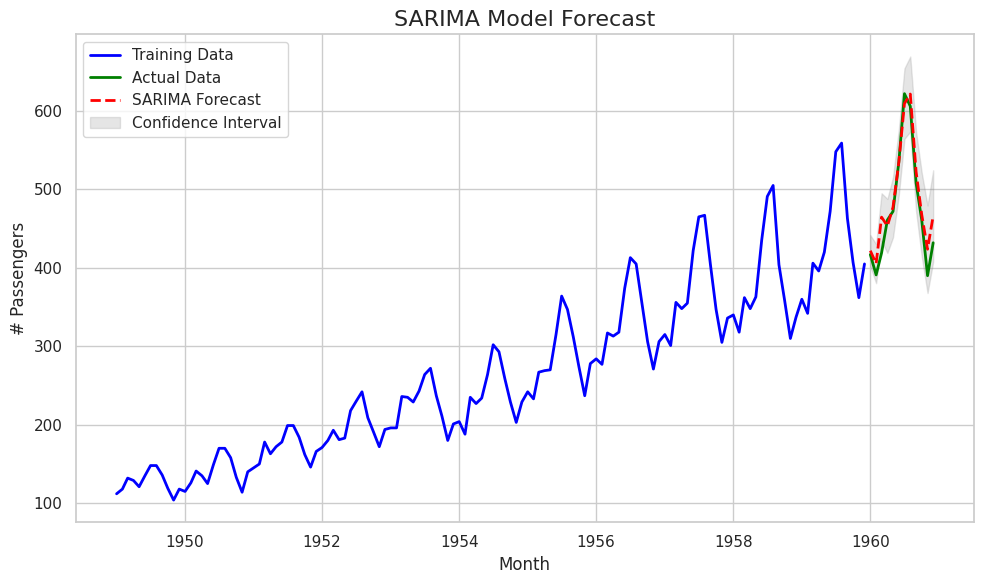

In [ ]:

# Plotting the SARIMA forecast using Matplotlib
plt.figure(figsize=(10, 6))

# Plot training data
plt.plot(train.index, train['#Passengers'], label='Training Data', color='blue', linestyle='-', linewidth=2)

# Plot actual test data
plt.plot(test.index, test['#Passengers'], label='Actual Data', color='green', linestyle='-', linewidth=2)

# Plot SARIMA forecast
plt.plot(test.index, forecast_mean_sarima, label='SARIMA Forecast', color='red', linestyle='--', linewidth=2)

# Plot confidence interval (shaded area)
plt.fill_between(test.index,
                 confidence_interval_sarima.iloc[:, 0],
                 confidence_interval_sarima.iloc[:, 1],
                 color='gray', alpha=0.2, label='Confidence Interval')

# Adding title and labels
plt.title('SARIMA Model Forecast', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('# Passengers', fontsize=12)

# Add grid for better readability
plt.grid(True)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
# Calculate performance metrics
mae = mean_absolute_error(test['#Passengers'], forecast_mean_sarima)
mse = mean_squared_error(test['#Passengers'], forecast_mean_sarima)
rmse = sqrt(mse)

print(f"SARIMA Model Performance:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

SARIMA Model Performance:
Mean Absolute Error (MAE): 16.278636484722465
Mean Squared Error (MSE): 446.7177695348393
Root Mean Squared Error (RMSE): 21.13569893651117


In both ARIMA and SARIMA examples, the results.predict() function is used to generate forecasts starting from the end of the historical data to the end of the future dates.

In [ ]:
results_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          #Passengers   No. Observations:                  132
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -445.700
Date:                              Mon, 21 Apr 2025   AIC                            903.400
Time:                                      02:20:53   BIC                            920.075
Sample:                                  01-01-1949   HQIC                           910.171
                                       - 12-01-1959                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5051      0.615     -0.822      0.411      -1.710       0.699
ma.L1          0.2644      0.634      0.417      0.676      -0.977       1.506
ma.L2         -0.0054      0.207     -0.026      0.979      -0.412       0.401
ar.S.L12      -0.9985      0.175     -5.720      0.000      -1.341      -0.656
ma.S.L12       0.9816      1.053      0.933      0.351      -1.081       3.045
sigma2        98.8700     83.206      1.188      0.235     -64.210     261.950
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.57
Prob(Q):                              0.98   Prob(JB):                         0.75
Heteroskedasticity (H):               1.56   Skew:                            -0.06
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Performance Comparison Between ARIMA and SRIMA


- Log Likelihood: The SARIMA model (-443.523) has a better fit than the ARIMA model (-607.782).
- AIC: The SARIMA model has a much lower AIC (901.046) compared to the ARIMA model (1225.563), which suggests that - SARIMA is a better fit for the data.
- BIC: The SARIMA model's BIC is also lower (920.500 vs. 1239.939).

In [ ]:

# Forecast for the next 12 months using SARIMA model
forecast_sarima = results_sarima.get_forecast(steps=12)
sarima_forecast_values = forecast_sarima.predicted_mean  # Predicted values
sarima_conf_int = forecast_sarima.conf_int()  # Confidence intervals

# Create a DataFrame for predictions and confidence intervals
forecast_index = pd.date_range(start=test.index[-1], periods=13, freq='MS')[1:]  # Adjust index for future dates

sarima_forecast_df = pd.DataFrame({
    'Forecasted Passengers': sarima_forecast_values.values,
    'Lower CI': sarima_conf_int.iloc[:, 0].values,
    'Upper CI': sarima_conf_int.iloc[:, 1].values
}, index=forecast_index)

# Display the forecast DataFrame
print(sarima_forecast_df)


            Forecasted Passengers    Lower CI    Upper CI
1961-01-01             421.860970  402.001670  441.720270
1961-02-01             405.365355  380.440594  430.290117
1961-03-01             464.657036  434.279762  495.034309
1961-04-01             453.438899  419.011148  487.866649
1961-05-01             477.237681  438.934379  515.540982
1961-06-01             534.775448  493.072420  576.478475
1961-07-01             609.397926  564.496892  654.298960
1961-08-01             621.528586  573.668790  669.388382
1961-09-01             522.561386  471.903080  573.219693
1961-10-01             467.894932  414.590434  521.199430
1961-11-01             423.738193  367.910666  479.565719
1961-12-01             466.111772  407.870409  524.353134


##**Step by step code walkthrough:**

---

###  **Code Summary:**
This block of code is forecasting the **next 12 months** of airline passengers using a trained **SARIMA model**, and then creating a **DataFrame** that includes:
- Forecasted values
- Confidence intervals (Upper and Lower bounds)

---


#### 1. **Forecasting the next 12 months**
```python
forecast_sarima = results_sarima.get_forecast(steps=12)
```
- This tells the SARIMA model (`results_sarima`) to **predict the next 12 time steps**.
- The result `forecast_sarima` contains both the predicted values and statistical information like confidence intervals.

---

#### 2. **Extract predicted values**
```python
sarima_forecast_values = forecast_sarima.predicted_mean
```
- This extracts just the **forecasted mean values** — i.e., the most likely passenger numbers for each of the 12 months.

---

#### 3. **Extract confidence intervals**
```python
sarima_conf_int = forecast_sarima.conf_int()
```
- Confidence intervals give you an **uncertainty range** for each forecast.
  - **The model isn’t just giving you a single predicted number — it’s saying, “I’m 95% confident the actual value will be between X and Y.”**
- `sarima_conf_int` will be a DataFrame with two columns:
  - Lower bound
  - Upper bound

---

#### 4. **Create a date index for future months**
```python
forecast_index = pd.date_range(start=test.index[-1], periods=13, freq='MS')[1:]
```
- We need to assign **future dates** to the forecasted values.
- `test.index[-1]`: Gets the last date in the test dataset.
- `pd.date_range(..., periods=13)`: Generates **13 dates**, starting from the last test date.
- `[1:]`: Slices to get the **next 12 months** (because the first one is the last test date, which we skip).

---

#### 5. **Create a forecast DataFrame**
```python
sarima_forecast_df = pd.DataFrame({
    'Forecasted Passengers': sarima_forecast_values.values,
    'Lower CI': sarima_conf_int.iloc[:, 0].values,
    'Upper CI': sarima_conf_int.iloc[:, 1].values
}, index=forecast_index)
```
- This creates a **clean table** (DataFrame) where:
  - Each row represents a month in the future.
  - Columns:
    - `'Forecasted Passengers'`: Predicted values
    - `'Lower CI'`: Lower bound of the confidence interval
    - `'Upper CI'`: Upper bound of the confidence interval
- The index (rows) are the **future months**.

---

#### 6. **Display the DataFrame**
```python
print(sarima_forecast_df)
```
- Finally, it prints the DataFrame that shows:
  - Forecasted values
  - The range (CI) within which the true values are expected to fall

---


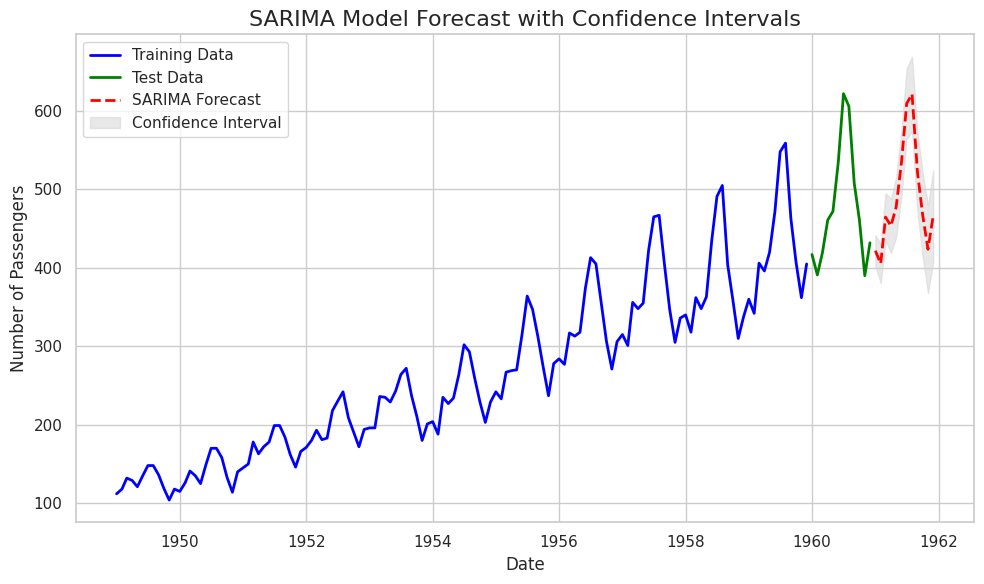

In [ ]:
# Plotting the SARIMA forecast with confidence intervals
plt.figure(figsize=(10, 6))

# Plot the training data
plt.plot(train.index, train['#Passengers'], label='Training Data', color='blue', linestyle='-', linewidth=2)

# Plot the test data
plt.plot(test.index, test['#Passengers'], label='Test Data', color='green', linestyle='-', linewidth=2)

# Plot the SARIMA forecast
plt.plot(sarima_forecast_df.index, sarima_forecast_df['Forecasted Passengers'],
         label='SARIMA Forecast', color='red', linestyle='--', linewidth=2)

# Add confidence intervals as shaded areas
plt.fill_between(sarima_forecast_df.index,
                 sarima_forecast_df['Lower CI'],
                 sarima_forecast_df['Upper CI'],
                 color='lightgrey', alpha=0.5, label='Confidence Interval')
#alpha ranges from 0 (completely transparent) to 1 (completely opaque).


# Adding title and labels
plt.title('SARIMA Model Forecast with Confidence Intervals', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)

# Add grid for better readability
plt.grid(True)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Plotting Actul vs Predicted  ARIMA

In [ ]:
# Adding the predicted values from ARIMA model to the dataset
df['Predicted_Passengers_ARIMA'] = results_arima.predict(start=0, end=len(df) - 1)

# Creating a DataFrame that contains both actual and predicted values
actual_vs_predicted_arima_df = df[['#Passengers', 'Predicted_Passengers_ARIMA']]

# Display the DataFrame to check the actual vs predicted values
actual_vs_predicted_arima_df.head()


,#Passengers,Predicted_Passengers_ARIMA
Month,,
1949-01-01,112,0.000000
1949-02-01,118,112.022180
1949-03-01,132,119.198367
1949-04-01,129,133.841792
1949-05-01,121,123.525510


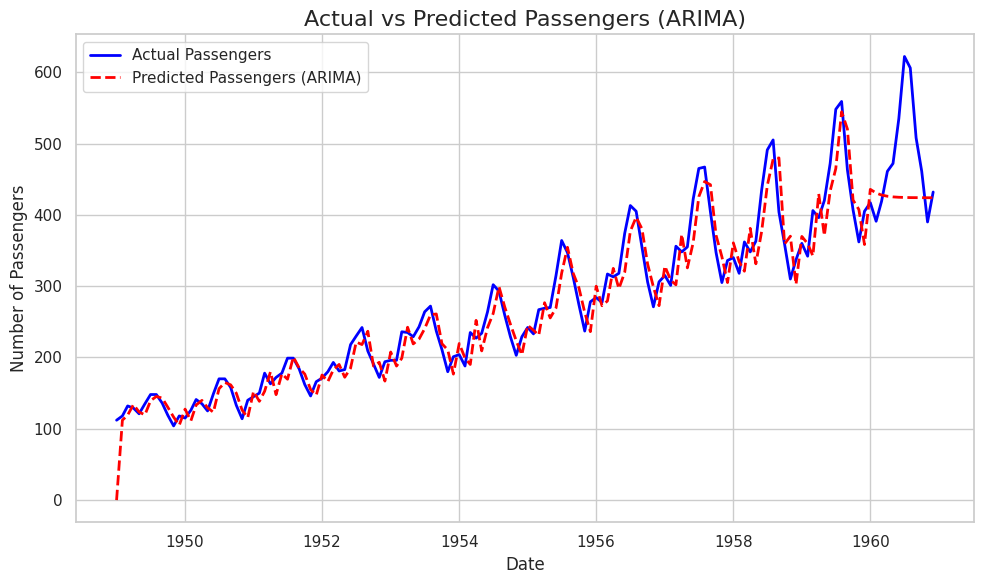

In [ ]:
# Plotting Actual vs Predicted Passengers for ARIMA
plt.figure(figsize=(10, 6))

# Plot the actual passenger data
plt.plot(df.index, df['#Passengers'], label='Actual Passengers', color='blue', linestyle='-', linewidth=2)

# Plot the predicted passenger data (ARIMA)
plt.plot(df.index, df['Predicted_Passengers_ARIMA'], label='Predicted Passengers (ARIMA)', color='red', linestyle='--', linewidth=2)

# Add title and labels
plt.title('Actual vs Predicted Passengers (ARIMA)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)

# Add grid for better readability
plt.grid(True)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Plotting Actul vs Predicted  SARIMA

In [ ]:
# Adding the predicted values from SARIMA model to the dataset
df['Predicted_Passengers'] = results_sarima.predict(start=0, end=len(df) - 1)

# Creating a DataFrame that contains both actual and predicted values
actual_vs_predicted_df = df[['#Passengers', 'Predicted_Passengers']]

# Display the DataFrame to check the actual vs predicted values
actual_vs_predicted_df.head()


,#Passengers,Predicted_Passengers
Month,,
1949-01-01,112,0.000000
1949-02-01,118,111.998320
1949-03-01,132,118.000636
1949-04-01,129,131.999256
1949-05-01,121,129.000457


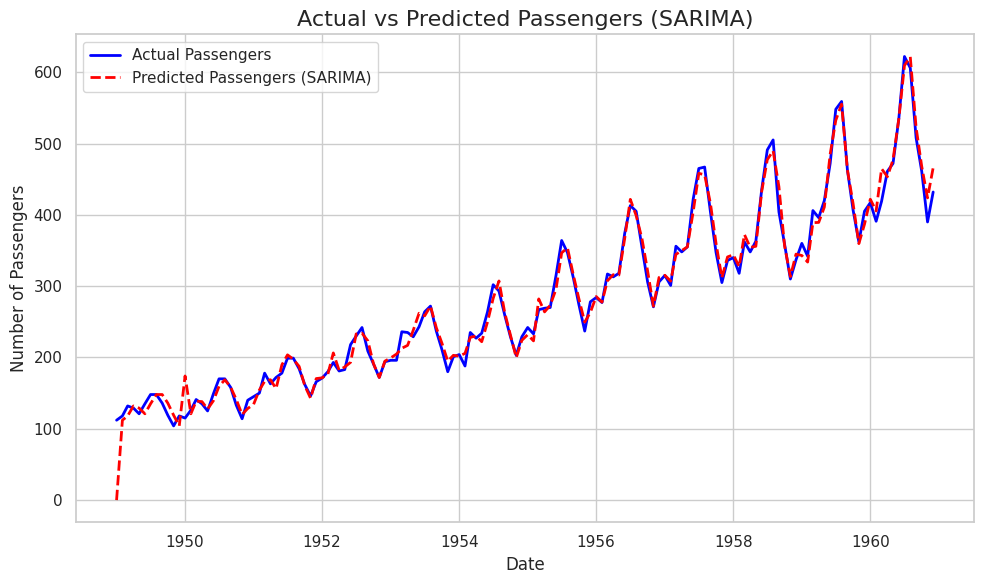

In [ ]:
# Plotting Actual vs Predicted Passengers for SARIMA
plt.figure(figsize=(10, 6))

# Plot the actual passenger data
plt.plot(df.index, df['#Passengers'], label='Actual Passengers', color='blue', linestyle='-', linewidth=2)

# Plot the predicted passenger data (SARIMA)
plt.plot(df.index, df['Predicted_Passengers'], label='Predicted Passengers (SARIMA)', color='red', linestyle='--', linewidth=2)

# Add title and labels
plt.title('Actual vs Predicted Passengers (SARIMA)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)

# Add grid for better readability
plt.grid(True)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Conclusion
Compared to ARIMA, SARIMA handles seasonality better and is a more suitable choice when seasonality is present.

Additionally, SARIMA outperforms ARIMA in all metrics, offering a better fit with lower log likelihood, AIC, and BIC, and significantly reducing MAE, MSE, and RMSE. Its ability to handle seasonality makes it the more reliable model for this airline passenger dataset.

# When to use ARIMA and SRIMA

* Choose ARIMA when seasonality is not a concern, or for shorter-term analysis.
* Choose SARIMA when the data has strong seasonal patterns that recur at regular intervals and require explicit modeling to improve forecasting accuracy.

> **SARIMA is generally a more robust model for real-world data that exhibits both trend and seasonal patterns, while ARIMA is ideal for non-seasonal datasets.**